# Validate Attention Attribution Results
This notebook contains the functions used to validate the unexpected results encountered in the attention attribution experiments for the mBart50 model.
> The subset sizes of all datasets have been reduced to 16 for faster processing. To fully recreate the results from the paper, please use the full datasets or set them to a higher number of samples (at least 1000).

In [1]:
from datasets import load_from_disk
import inseq
from inseq.data.aggregator import (
    AggregatorPipeline,
    SubwordAggregator,
    SequenceAttributionAggregator,
)
from iwslt import preprocess
from rude_nmt import analysis
import json


First, the datasets are loaded 

In [2]:
ds = load_from_disk("../data/tatoeba_filtered")

iwslt_en_only = preprocess.get_iwslt(
    categories=["telephony", "topical_chat", "test"], languages=["en"]
)


#### removed 0 old cache files ####


## mBart50
analyze the attention attribution for the mBart50 model.

First the model and feature attribution methods are loaded.

In [3]:
aggregator = AggregatorPipeline([SubwordAggregator])


In [4]:
mbart_model_de_ko = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "de_DE", "tgt_lang": "ko_KR"},
)


In [5]:
mbart_model_ko_de = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "ko_KR", "tgt_lang": "de_DE"},
)


The attributions are calculated for the German -> Korean translation direction with forced decoding.

In [6]:
mbart_attributions_de_ko_forced = mbart_model_de_ko.attribute(
    input_texts=ds[0:16]["source"],
    generated_texts=ds[0:16]["ko_nmt"],
    attribute_target=False,
    batch_size=32,
)
mbart_attributions_de_ko_forced = mbart_attributions_de_ko_forced.aggregate(
    aggregator=aggregator
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Attributing with attention...: 100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


In [7]:
mbart_attributions_de_ko_forced.sequence_attributions[0].show()


,ko_KR,"▁캐롤,",▁여기,▁Vincent이,▁있습니다.,▁말하지,▁마세요.,▁그냥,▁들어보세요.,</s>
de_DE,0.195,0.266,0.31,0.316,0.218,0.243,0.195,0.259,0.2,0.196
"▁Carol,",0.07,0.205,0.025,0.005,0.018,0.005,0.022,0.003,0.01,0.046
▁hier,0.012,0.039,0.029,0.007,0.01,0.007,0.004,0.002,0.004,0.008
▁ist,0.008,0.019,0.023,0.008,0.004,0.002,0.002,0.0,0.003,0.004
▁Vincent.,0.024,0.094,0.138,0.129,0.039,0.024,0.016,0.005,0.019,0.052
▁Sag,0.016,0.017,0.015,0.01,0.049,0.084,0.008,0.004,0.003,0.008
▁nichts.,0.012,0.022,0.025,0.009,0.038,0.057,0.01,0.004,0.003,0.007
▁Hör,0.016,0.005,0.002,0.001,0.017,0.022,0.047,0.053,0.025,0.011
▁bloß,0.014,0.007,0.001,0.002,0.019,0.024,0.043,0.071,0.011,0.012
▁zu.,0.011,0.003,0.002,0.003,0.01,0.022,0.026,0.048,0.035,0.005


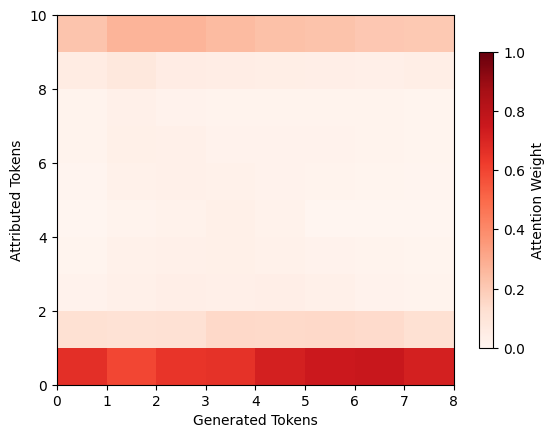

In [8]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_de_ko_forced.sequence_attributions
]
analysis.create_interpolation_plot_single(
    analysis.interpolate_attributions(source_attr), plt_name="../plots/de_ko_forced"
)


For comparison, the attributions for the German -> Korean direction are calculated again without forced decoding.

As expected, no difference in attributions is observed.

In [9]:
mbart_attributions_de_ko_free = mbart_model_de_ko.attribute(
    input_texts=ds[0:16]["source"],
    generation_args={
        "forced_bos_token_id": mbart_model_de_ko.tokenizer.lang_code_to_id["ko_KR"]
    },
    attribute_target=False,
    batch_size=4,
)
mbart_attributions_de_ko_free = mbart_attributions_de_ko_free.aggregate(
    aggregator=aggregator
)


/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (200) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Attributing with attention...: 100%|██████████| 27/27 [00:05<00:00,  4.76it/s]


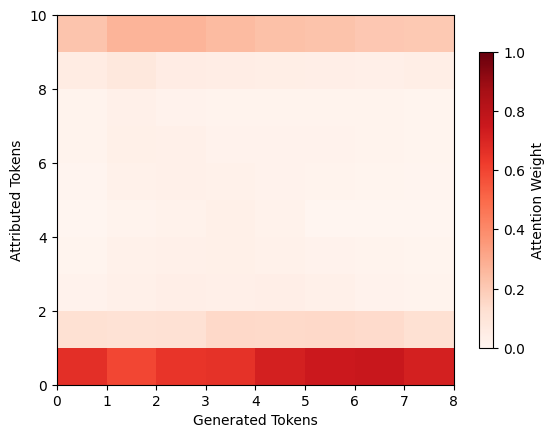

In [10]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_de_ko_free.sequence_attributions
]
analysis.create_interpolation_plot_single(
    analysis.interpolate_attributions(source_attr), plt_name="../plots/de_ko_free"
)


To set the interpolation maps of the attention attribution method into context and exclude any technical issues, the interpolation map for the Input x Gradient method is also calculated.

In [11]:
mbart_attributions_de_ko_inp_grad = mbart_model_de_ko.attribute(
    input_texts=ds[0:16]["source"],
    generated_texts=ds[0:16]["ko_nmt"],
    attribute_target=False,
    batch_size=8,
    method="input_x_gradient",
)
mbart_attributions_de_ko_inp_grad = mbart_attributions_de_ko_inp_grad.aggregate(
    aggregator=AggregatorPipeline([SubwordAggregator, SequenceAttributionAggregator])
)


Attributing with input_x_gradient...: 100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


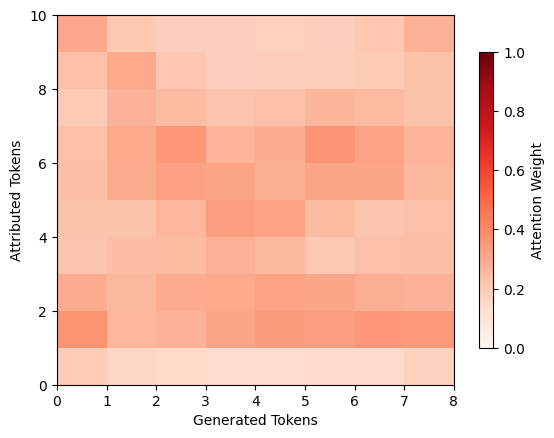

In [12]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_de_ko_inp_grad.sequence_attributions
]
analysis.create_interpolation_plot_single(
    analysis.interpolate_attributions(source_attr, scale_factor=2),
    plt_name="../plots/de_ko_inp_grad"
)


The attributions are also calculated for the Korean -> German translation direction with forced decoding.

In [9]:
mbart_attributions_ko_de_forced = mbart_model_ko_de.attribute(
    input_texts=ds[0:16]["target"],
    generated_texts=ds[0:16]["de_nmt"],
    attribute_target=False,
    batch_size=32,
)
mbart_attributions_ko_de_forced = mbart_attributions_ko_de_forced.aggregate(
    aggregator=aggregator
)


Attributing with attention...:   5%|▌         | 1/20 [00:00<?, ?it/s]

Attributing with attention...: 100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


In [10]:
mbart_attributions_ko_de_forced.sequence_attributions[0].show()


,de_DE,"▁Carol,",▁don't,▁say,"▁""Naya","▁Vincent""!",</s>
ko_KR,0.201,0.229,0.241,0.214,0.215,0.227,0.213
"▁캐럴,",0.033,0.124,0.024,0.005,0.019,0.009,0.021
▁나야,0.007,0.026,0.058,0.039,0.072,0.004,0.004
▁빈센트,0.005,0.038,0.045,0.081,0.206,0.12,0.007
▁말하지,0.007,0.011,0.024,0.047,0.012,0.013,0.01
▁말고,0.017,0.068,0.063,0.022,0.011,0.02,0.017
▁들어,0.021,0.02,0.037,0.027,0.014,0.054,0.052
</s>,0.641,0.565,0.709,0.469,0.649,0.746,0.646


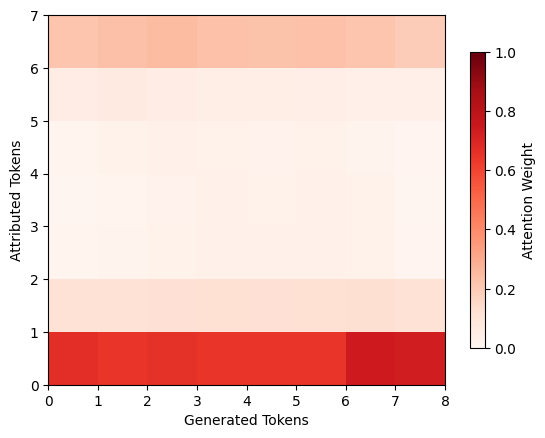

In [11]:
source_attr = [
    attr.source_attributions
    for attr in mbart_attributions_ko_de_forced.sequence_attributions
]
analysis.create_interpolation_plot_single(
    analysis.interpolate_attributions(source_attr), plt_name="../plots/ko_de_forced"
)


To verify the attribution scores with other languages, the attributions are also calculated for the German -> English and Korean -> English translation directions.

In [12]:
mbart_model_de_en = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "de_DE", "tgt_lang": "en_XX"},
)


In [13]:
mbart_model_ko_en = inseq.load_model(
    "facebook/mbart-large-50-many-to-many-mmt",
    "attention",
    tokenizer_kwargs={"src_lang": "ko_KR", "tgt_lang": "en_XX"},
)


In [14]:
mbart_attributions_de_en = mbart_model_de_en.attribute(
    input_texts=ds[0:16]["source"],
    generation_args={
        "forced_bos_token_id": mbart_model_de_en.tokenizer.lang_code_to_id["en_XX"]
    },
    attribute_target=False,
    batch_size=16,
)
mbart_attributions_de_en = mbart_attributions_de_en.aggregate(aggregator=aggregator)


/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/Users/lsickert/Repositories/rude-nmt/.venv/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (200) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Attributing with attention...: 100%|██████████| 19/19 [00:05<00:00,  3.25it/s]


In [15]:
mbart_attributions_de_en.sequence_attributions[0].show()


,en_XX,"▁Carol,",▁here's,▁Vincent.,▁Don't,▁say,▁anything.,▁Just,▁listen.,</s>
de_DE,0.195,0.258,0.244,0.314,0.227,0.193,0.192,0.211,0.175,0.179
"▁Carol,",0.07,0.098,0.063,0.038,0.021,0.008,0.024,0.017,0.005,0.053
▁hier,0.012,0.067,0.04,0.021,0.027,0.009,0.008,0.005,0.003,0.013
▁ist,0.008,0.026,0.024,0.016,0.008,0.005,0.004,0.002,0.002,0.006
▁Vincent.,0.024,0.086,0.141,0.138,0.051,0.021,0.032,0.014,0.012,0.053
▁Sag,0.016,0.017,0.02,0.022,0.059,0.042,0.023,0.01,0.009,0.013
▁nichts.,0.012,0.026,0.027,0.02,0.04,0.025,0.028,0.007,0.005,0.009
▁Hör,0.016,0.007,0.006,0.008,0.014,0.015,0.033,0.068,0.045,0.02
▁bloß,0.014,0.01,0.005,0.009,0.015,0.009,0.03,0.049,0.03,0.017
▁zu.,0.011,0.008,0.015,0.009,0.013,0.009,0.016,0.024,0.029,0.007


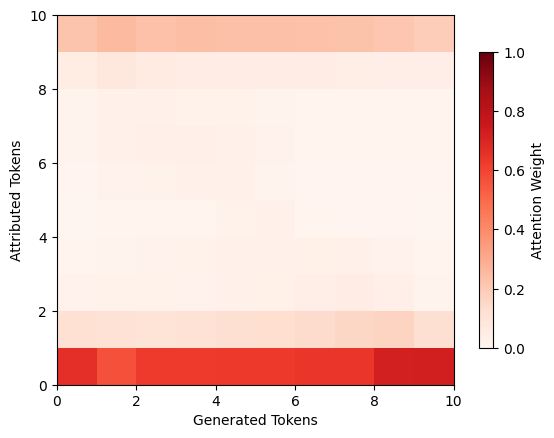

In [17]:
source_attr = [
    attr.source_attributions for attr in mbart_attributions_de_en.sequence_attributions
]
analysis.create_interpolation_plot_single(
    analysis.interpolate_attributions(source_attr), plt_name="../plots/de_en"
)


In [18]:
mbart_attributions_ko_en = mbart_model_ko_en.attribute(
    input_texts=ds[0:16]["source"],
    generation_args={
        "forced_bos_token_id": mbart_model_ko_en.tokenizer.lang_code_to_id["en_XX"]
    },
    attribute_target=False,
    batch_size=8,
)
mbart_attributions_ko_en = mbart_attributions_ko_en.aggregate(aggregator=aggregator)


Attributing with attention...: 100%|██████████| 20/20 [00:03<00:00,  4.77it/s]


In [19]:
mbart_attributions_ko_en.sequence_attributions[0].show()


,en_XX,"▁Carol,",▁here,▁is,▁Vincent.,▁Say,▁nothing.,▁Just,▁listen,▁to,▁me.,</s>
ko_KR,0.194,0.26,0.23,0.199,0.31,0.242,0.193,0.208,0.157,0.154,0.19,0.166
"▁Carol,",0.072,0.085,0.048,0.011,0.019,0.034,0.024,0.008,0.004,0.007,0.014,0.037
▁hier,0.011,0.068,0.045,0.015,0.017,0.017,0.006,0.002,0.002,0.002,0.005,0.01
▁ist,0.007,0.026,0.024,0.039,0.023,0.007,0.006,0.001,0.004,0.005,0.005,0.006
▁Vincent.,0.019,0.055,0.08,0.061,0.089,0.039,0.019,0.006,0.012,0.024,0.041,0.032
▁Sag,0.022,0.046,0.02,0.007,0.052,0.105,0.032,0.015,0.012,0.005,0.008,0.028
▁nichts.,0.009,0.021,0.014,0.008,0.023,0.049,0.021,0.006,0.006,0.008,0.007,0.008
▁Hör,0.02,0.013,0.007,0.003,0.012,0.02,0.036,0.082,0.06,0.018,0.021,0.021
▁bloß,0.013,0.012,0.005,0.003,0.01,0.022,0.025,0.054,0.029,0.029,0.019,0.015
▁zu.,0.012,0.016,0.019,0.015,0.029,0.028,0.05,0.091,0.117,0.101,0.103,0.034


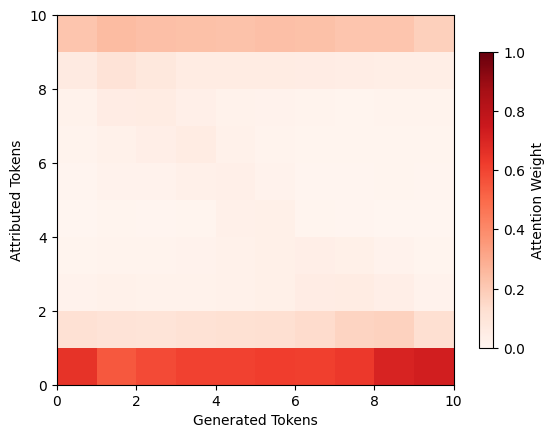

In [20]:
source_attr = [
    attr.source_attributions for attr in mbart_attributions_ko_en.sequence_attributions
]
analysis.create_interpolation_plot_single(
    analysis.interpolate_attributions(source_attr), plt_name="../plots/ko_en"
)


## NLLB
analyze the attention attribution on the NLLB model to verify if the pattern can be observed in other models as well

In [21]:
nllb_de_ko_model = inseq.load_model(
    "facebook/nllb-200-distilled-600M",
    "attention",
    tokenizer_kwargs={"src_lang": "deu_Latn", "tgt_lang": "kor_Hang"},
)


In [22]:
nllb_ko_de_model = inseq.load_model(
    "facebook/nllb-200-distilled-600M",
    "attention",
    tokenizer_kwargs={"src_lang": "kor_Hang", "tgt_lang": "deu_Latn"},
)


In [23]:
nllb_attributions_de_ko = nllb_de_ko_model.attribute(
    input_texts=ds[0:16]["source"],
    generation_args={
        "forced_bos_token_id": nllb_de_ko_model.tokenizer.lang_code_to_id["kor_Hang"]
    },
    attribute_target=False,
    batch_size=8,
)

nllb_attributions_de_ko = nllb_attributions_de_ko.aggregate(aggregator=aggregator)


Attributing with attention...: 100%|██████████| 18/18 [00:03<00:00,  5.01it/s]


In [24]:
nllb_attributions_de_ko.sequence_attributions[0].show()


,kor_Hang,"▁캐롤,",▁빈센트입니다.,▁아무,▁말도,▁하지,▁마요.,▁그냥,▁들어봐요.,</s>
deu_Latn,0.436,0.016,0.007,0.002,0.0,0.002,0.012,0.003,0.028,0.007
"▁Carol,",0.001,0.314,0.012,0.003,0.001,0.002,0.02,0.003,0.007,0.018
▁hier,0.001,0.067,0.107,0.012,0.001,0.001,0.003,0.002,0.004,0.008
▁ist,0.001,0.058,0.104,0.013,0.002,0.002,0.003,0.003,0.004,0.007
▁Vincent.,0.017,0.307,0.396,0.018,0.002,0.005,0.008,0.006,0.01,0.058
▁Sag,0.002,0.009,0.141,0.159,0.04,0.049,0.017,0.007,0.008,0.013
▁nichts.,0.018,0.027,0.194,0.184,0.036,0.092,0.054,0.029,0.031,0.013
▁Hör,0.002,0.003,0.013,0.013,0.001,0.005,0.06,0.08,0.078,0.02
▁bloß,0.001,0.002,0.009,0.006,0.0,0.004,0.031,0.06,0.011,0.009
▁zu.,0.026,0.012,0.014,0.01,0.004,0.009,0.053,0.06,0.082,0.026


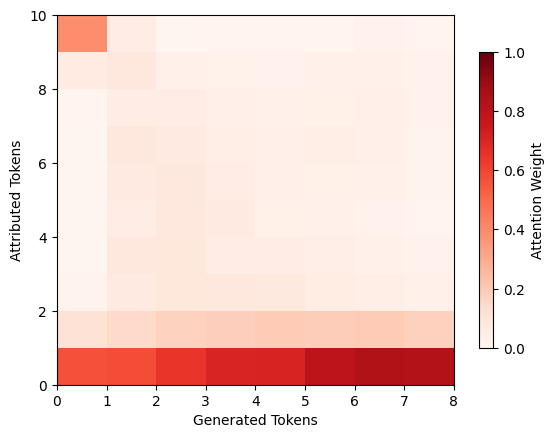

In [25]:
source_attr = [
    attr.source_attributions for attr in nllb_attributions_de_ko.sequence_attributions
]
analysis.create_interpolation_plot_single(
    analysis.interpolate_attributions(source_attr), plt_name="../plots/nllb_de_ko"
)


In [26]:
nllb_attributions_ko_de = nllb_ko_de_model.attribute(
    input_texts=ds[0:16]["source"],
    generation_args={
        "forced_bos_token_id": nllb_ko_de_model.tokenizer.lang_code_to_id["deu_Latn"]
    },
    attribute_target=False,
    batch_size=8,
)

nllb_attributions_ko_de = nllb_attributions_ko_de.aggregate(aggregator=aggregator)


Attributing with attention...: 100%|██████████| 21/21 [00:04<00:00,  4.93it/s]


In [27]:
nllb_attributions_ko_de.sequence_attributions[0].show()


,deu_Latn,"▁Carol,",▁hier,▁ist,▁Vincent.,▁Sag,▁nichts.,▁Hör,▁bloß,▁zu.,</s>
kor_Hang,0.619,0.048,0.014,0.012,0.039,0.031,0.026,0.02,0.009,0.021,0.028
"▁Carol,",0.002,0.206,0.046,0.006,0.016,0.026,0.037,0.025,0.002,0.005,0.033
▁hier,0.0,0.087,0.218,0.043,0.029,0.01,0.004,0.004,0.004,0.011,0.018
▁ist,0.0,0.032,0.027,0.198,0.046,0.001,0.004,0.0,0.008,0.006,0.004
▁Vincent.,0.007,0.066,0.163,0.105,0.261,0.02,0.008,0.007,0.004,0.017,0.033
▁Sag,0.0,0.083,0.166,0.014,0.165,0.149,0.063,0.01,0.002,0.011,0.054
▁nichts.,0.009,0.022,0.003,0.007,0.028,0.013,0.27,0.003,0.008,0.012,0.007
▁Hör,0.001,0.035,0.018,0.001,0.017,0.046,0.24,0.282,0.027,0.024,0.043
▁bloß,0.01,0.012,0.003,0.004,0.007,0.003,0.038,0.049,0.297,0.028,0.008
▁zu.,0.019,0.033,0.008,0.021,0.028,0.013,0.033,0.024,0.098,0.391,0.027


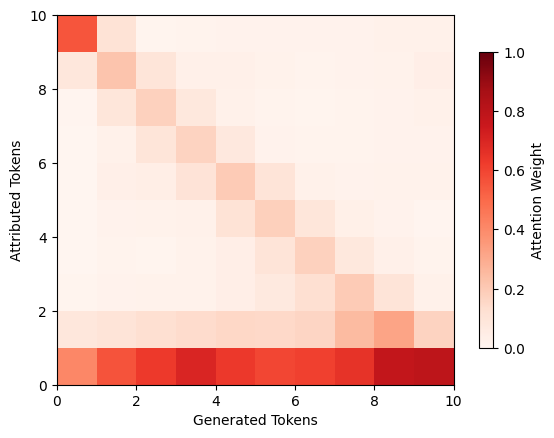

In [28]:
source_attr = [
    attr.source_attributions for attr in nllb_attributions_ko_de.sequence_attributions
]
analysis.create_interpolation_plot_single(
    analysis.interpolate_attributions(source_attr), plt_name="../plots/nllb_ko_de"
)


## OPUS-MT
analyze the attention attribution on the OPUS-MT model

In [ ]:
# "Helsinki-NLP/opus-mt-en-de"
opus_model = inseq.load_model("Helsinki-NLP/opus-mt-de-en", "attention")


In [ ]:
out = opus_model.attribute(
    input_texts=ds[0:16]["source"], attribute_target=False, batch_size=8
)
out.show()


## Multiple Interpolation Plots
create a single plot with data from multiple interpolation plots. This assumes that the script `get_interpol_plot_helper.py` has been run to obtain the combined json-data first.

In [29]:
data = {}
with open("../plots/interpolations.json", "r") as f:
    data = json.load(f)


In [30]:
for plot in data:
    plot["title"] = plot["title"].replace("->", r"$\rightarrow$")


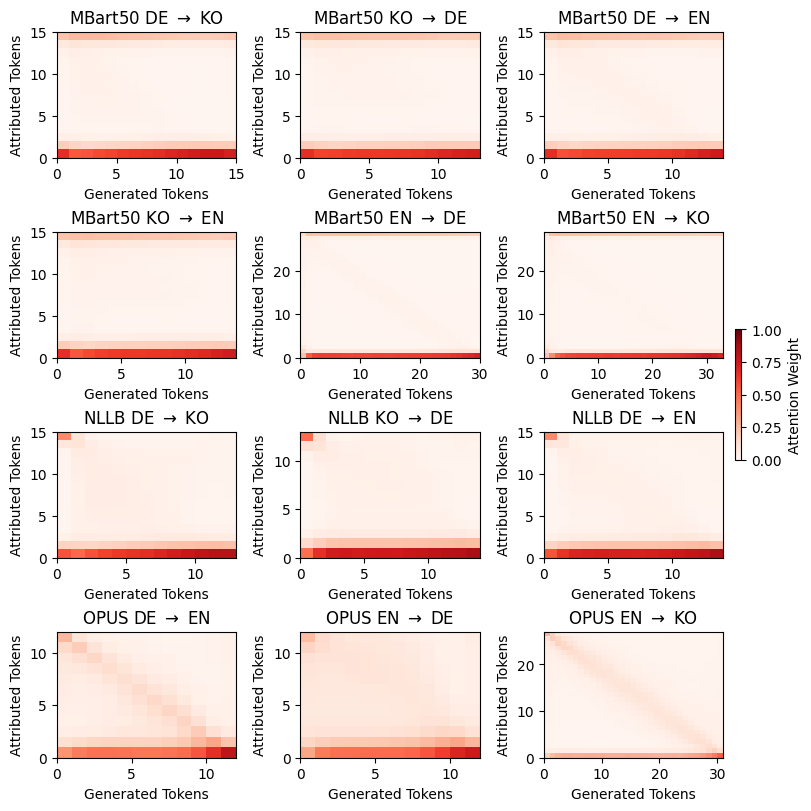

In [31]:
analysis.create_interpolation_plot_multi(
    data, save=True, plt_name="../plots/interpolations.png"
)
